## Rank Selection & Cophenetic Correlation

In [253]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import xarray as xr
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
import tensorly as tl

### Loading the data

In [254]:
MVBS_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_MVBS_envFromFile/'
MVBS_path = '../data/reproduced_MVBS_files/'
MVBS_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_all.nc'

In [255]:
MVBS = xr.open_dataset(os.path.join(MVBS_path, MVBS_file))
MVBS

<xarray.Dataset>
Dimensions:    (frequency: 3, ping_time: 8928, range_bin: 41)
Coordinates:
  * range_bin  (range_bin) int64 0 1 2 3 4 5 6 7 8 ... 33 34 35 36 37 38 39 40
  * frequency  (frequency) float32 120000.0 38000.0 200000.0
  * ping_time  (ping_time) datetime64[ns] 2015-08-17 ... 2015-10-17T23:16:40
Data variables:
    MVBS       (range_bin, ping_time, frequency) float64 ...
    range      (ping_time, range_bin) float64 ...

In [256]:
#MVBS_PCP_path = '/Users/wu-jung/code_git/ooi_sonar/zplsc_data_2015fall/nc_PCP_envFromFile/'
MVBS_PCP_path = '../data/reproduced_MVBS_files/'
MVBS_rpca_file = '20150817-20151017_MVBS_time_from_Sv_rangeBin5_rpca.nc'

In [257]:
MVBS_rpca = xr.open_dataset(os.path.join(MVBS_PCP_path, MVBS_rpca_file))
MVBS_rpca

<xarray.Dataset>
Dimensions:    (date: 62, depth: 37, frequency: 3, hour: 144)
Coordinates:
  * date       (date) datetime64[ns] 2015-08-17 2015-08-18 ... 2015-10-17
  * frequency  (frequency) int64 38000 120000 200000
  * depth      (depth) float64 184.0 179.0 174.0 169.0 ... 14.91 9.943 4.972
  * hour       (hour) float64 0.0 0.1667 0.3333 0.5 ... 23.33 23.5 23.67 23.83
Data variables:
    low_rank   (date, frequency, depth, hour) float64 ...
    sparse     (date, frequency, depth, hour) float64 ...

In [258]:
low_rank = MVBS_rpca['low_rank']
low_rank.shape

(62, 3, 37, 144)

In [259]:
n_observations, n_frequencies, n_depth_levels, n_pins = low_rank.shape

In [260]:
low_rank = low_rank.values.reshape([n_observations,-1])
low_rank.shape

(62, 15984)

In [261]:
low_rank_nonneg = low_rank - low_rank.min()

In [262]:
low_rank_nonneg.shape

(62, 15984)

In [263]:
X = (low_rank_nonneg/np.std(low_rank_nonneg.T, axis=1)).T

### Multiple Runs
Here we run the decomposition multiple times with different initial conditions.

In [264]:
# perform this step once to install the ssnmf package
!pip install --upgrade git+https://github.com/valentina-s/ss-nmf.git

  Cloning https://github.com/valentina-s/ss-nmf.git to /private/var/folders/fq/3s4jskh93cv0__zlk6lw0l780000gn/T/pip-req-build-betgvgvl
  Running command git clone -q https://github.com/valentina-s/ss-nmf.git /private/var/folders/fq/3s4jskh93cv0__zlk6lw0l780000gn/T/pip-req-build-betgvgvl
  Created wheel for ss-nmf: filename=ss_nmf-VERSION-cp37-none-any.whl size=464207 sha256=6e7c3f44fcc4efb60419bb337d9806044ddd2a4f650cd09451f0ee5f3e5273c1
  Stored in directory: /private/var/folders/fq/3s4jskh93cv0__zlk6lw0l780000gn/T/pip-ephem-wheel-cache-dga3gtlh/wheels/ee/7c/86/e2ef077ff7db547ab1ac9304320edcb62ea9df3420f458b54c
Successfully built ss-nmf
  Found existing installation: ss-nmf VERSION
    Uninstalling ss-nmf-VERSION:
      Successfully uninstalled ss-nmf-VERSION


In [266]:
%%time
# setting the model parameters
import ssnmf
model = ssnmf.smoothNMF(n_components=3, max_iter=20000, betaW=0.1, betaH=0.1, smoothness=5000000, sparsity=0.5)
# model.fit(X, init='random')

CPU times: user 65 µs, sys: 552 µs, total: 617 µs
Wall time: 642 µs


### Consensus Matrix 

In [217]:
import copy
# consensus function
# it does not work for model_save & parallel
# should have an option to set the random state

from itertools import repeat

def consensus(n_runs, X, model, parallel=False, model_save=False):
    """
    Compute consensus matrix as the mean connectivity matrix across multiple runs of the factorization. It has been
    proposed by [Brunet2004]_ to help visualize and measure the stability of the clusters obtained by NMF.
        
    Tracking of matrix factors across multiple runs must be enabled for computing consensus matrix. For results
    of a single NMF run, the consensus matrix reduces to the connectivity matrix.
        
    Inputs
    ------
    
    n_runs:     the number of times to run the model
    X:          the data array to decompose
    model:      an instance of an NMF class, containing the fitting parameters
    parallel:   if True, model runs are executed in parallel (threads)
    model_save: if set to True, returns a list of the fitted models
    
    Returns
    -------
    
    C           the consensus matrix of size (X.shape[1],X.shape[1])
    models      if model_save is True, a list of fitted models
    
    """    
    
    def get_connectivity(model):
        model_out = copy.deepcopy(model)
        model_out.fit(X, init='random')
        return(model_out.connectivity(), model_out)
        
    models = []
    if not parallel:
        cons = []
        for run in range(n_runs):
            model_out = copy.deepcopy(model)
            model_out.fit(X, init='random')
            if model_save:
                models.append(model_out)
            cons.append(model_out.connectivity())
        cons = np.array(cons)

    else:         
        from concurrent.futures import ThreadPoolExecutor
        ex = ThreadPoolExecutor()
        result = ex.map(get_connectivity, repeat(model,n_runs))
        cons, models = zip(*result)
        cons= np.array(list(cons))
        
    if model_save:
        return(np.sum(cons, axis=0)/n_runs, models)
    else:
        return(np.sum(cons, axis=0)/n_runs)

In [246]:
# coph_cor function (from Nimfa)
from scipy.cluster.hierarchy import linkage, cophenet
def coph_cor(X, model, n_runs = 1, parallel=False, model_save=False):
        """
        Compute cophenetic correlation coefficient of consensus matrix, generally obtained from multiple NMF runs. 
        
        The cophenetic correlation coefficient is measure which indicates the dispersion of the consensus matrix and is based 
        on the average of connectivity matrices. It measures the stability of the clusters obtained from NMF. 
        It is computed as the Pearson correlation of two distance matrices: the first is the distance between samples induced by the 
        consensus matrix; the second is the distance between samples induced by the linkage used in the reordering of the consensus 
        matrix [Brunet2004]_.
        
        Return real number. In a perfect consensus matrix, cophenetic correlation equals 1. When the entries in consensus matrix are
        scattered between 0 and 1, the cophenetic correlation is < 1. We observe how this coefficient changes as factorization rank 
        increases. We select the first rank, where the magnitude of the cophenetic correlation coefficient begins to fall [Brunet2004]_.
        
        :param idx: Used in the multiple NMF model. In factorizations following standard NMF model or nonsmooth NMF model
                    :param:`idx` is always None.
        :type idx: None or `str` with values 'coef' or 'coef1' (`int` value of 0 or 1, respectively) 
        """
        if model_save:
             A, models = consensus(n_runs, X, model, parallel = parallel, model_save=True)
        else:
            A = consensus(n_runs, X, model, parallel = parallel)
        # upper diagonal elements of consensus
        avec = np.array([A[i, j] for i in range(A.shape[0] - 1)
                        for j in range(i + 1, A.shape[1])])
        # consensus entries are similarities, conversion to distances
        Y = 1 - avec
        Z = linkage(Y, method='average')
        # cophenetic correlation coefficient of a hierarchical clustering
        # defined by the linkage matrix Z and matrix Y from which Z was
        # generated
        return (cophenet(Z, Y)[0], cophenet(Z,Y)[1], models)

In [ ]:
C, models = consensus(X=X, model=model, n_runs=4, parallel=False, model_save=True)

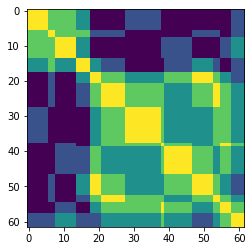

In [218]:
plt.imshow(C)

### Variation in Activations

In [223]:
Hs = [model.H for model in models]

In [241]:
# ordering the activations based on their correlation
def match_factors(Hs):
    Hs_ref = Hs[0]
    rank = Hs_ref.shape[0]
    Hs_new = [Hs_ref]
    for k in range(len(Hs)-1):
        # rho = (Hs_ref-Hs_ref.mean(axis=1).reshape(3,1))@(Hs[(3*(k+1)):((k+2)*3),:].T - Hs[(3*(k+1)):((k+2)*3),:].mean(axis=1).reshape(3,1).T)
        rho = np.corrcoef(Hs_ref, Hs[k+1])[:rank,rank:]  
        index = [0 for r in range(rank)]
        for p in range(rank):
            index_max = np.argmax(rho)
            # index = np.argsort(rho, axis=1)
            i,j = np.unravel_index(index_max,(rank,rank))
            rho[:,j] = -2
            rho[i,:] = -2
            index[i] = j
        Hs_new.append(Hs[k+1][index,:])
        
    return(Hs_new)

In [242]:
Hs_ordered = match_factors(Hs)

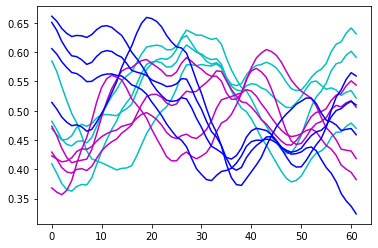

In [243]:
# displaying the activations corresponding to different components
g = plt.plot(np.vstack(Hs_ordered)[0::3].T,'c')
g = plt.plot(np.vstack(Hs_ordered)[1::3].T, 'm') 
g = plt.plot(np.vstack(Hs_ordered)[2::3].T,'b')

### Rank Estimation

In [251]:
# a function to estimate rank based on cophenetic correlation
def estimate_rank(ranks, X, model, n_runs=10, parallel=True):
    # run for different ranks
    c_dict = {}
    D_dict = {}
    models_dict = {}
    for r in ranks:
        print(r)
        model.rank = r
        c, D, models = coph_cor(X=X, model=model, n_runs=n_runs, parallel=parallel, model_save=True)
        c_dict[r] = c
        D_dict[r] = D
        models_dict[r] = models
    rank = max(c_dict.keys(), key=(lambda k: c_dict[k]))   
    return(rank, c_dict, D_dict, models)    

In [267]:
%%time
rank, c_dict, D_dict, models_dict = estimate_rank(ranks=range(2,10), X=X, model=model, n_runs=40, parallel=True)

2
3
4
5
6
7
8
9
CPU times: user 3d 15h 17min 24s, sys: 1d 19h 35min 43s, total: 5d 10h 53min 8s
Wall time: 23h 55min 18s


In [ ]:
# just saving the last models: should I save them all??

In [268]:
c_dict.values()

dict_values([0.91390462182192, 0.9556810915884559, 0.9553027301783003, 0.8878383568685653, 0.958451554673847, 0.9589464112490595, 0.9160325302145623, 0.9110771095107669])

Text(0.5, 0, 'Rank')

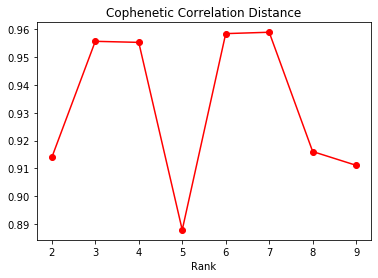

In [269]:
# plot the Cophenetic Correlation wrt to Rank
plt.plot(np.array(list(c_dict.keys())),list(c_dict.values()),'ro-')
plt.title("Cophenetic Correlation Distance")
plt.xlabel("Rank")

In [301]:
# saving variables
import pickle
f = open("cophenetic_smoothNMF.pkl", "wb") # remember to open the file in binary mode
pickle.dump([c_dict, D_dict, models_dict], f)
f.close()

In [302]:
# reading variables
with open('cophenetic_smoothNMF.pkl', 'rb') as f:
    c_dict1, D_dict1, models1 = pickle.load(f)

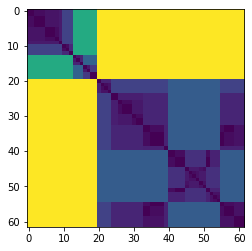

In [312]:
plt.imshow(squareform(D_dict[5]))

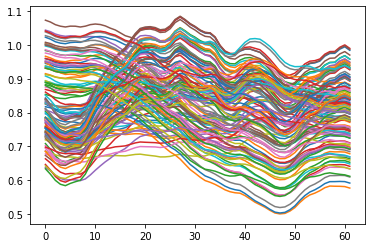

In [324]:
g = plt.plot(np.vstack([model.H for model in models]).T)

In [329]:
D_dict[5]

array([0.   , 0.025, 0.025, ..., 0.   , 0.   , 0.   ])

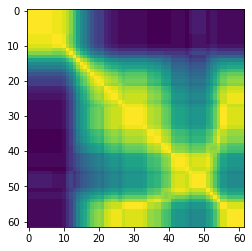

In [335]:
# Showing the consensus matrix for the last model (rank 9)
plt.imshow(np.array([model.connectivity() for model in models]).sum(axis=0))